<a href="https://colab.research.google.com/github/bismillahkani/Intro-to-recommender-systems/blob/master/Collobarative_filtering_using_FastAi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up

In [1]:
# Let's first download a utility file for setting up Google Colab
!wget https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py

--2020-04-28 10:23:41--  https://raw.githubusercontent.com/WittmannF/course-v4/master/utils/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1214 (1.2K) [text/plain]
Saving to: ‘colab_utils.py.1’

colab_utils.py.1    100%[===================>]   1.19K  --.-KB/s    in 0s      

2020-04-28 10:23:42 (190 MB/s) - ‘colab_utils.py.1’ saved [1214/1214]



In [2]:
from colab_utils import setup_fastai_colab
setup_fastai_colab()

    NOTE: For debugging and visualizing stdout, please run:
    from colab_utils import *
    !{REQUIREMENTS_PIP}
    !{GIT_CLONE_REPOSITORY}
    %cd {FASTAI_NB_PATH}

Installing requirements...
Done!
Cloning FastAI Repository...
Done!
Opening folder course-v4/nbs/ with nbs and utils files...
Done!


In [0]:
#hide
from utils import *

## A first look at the data

In [0]:
from fastai2.collab import *
from fastai2.tabular.all import *
path = untar_data(URLs.ML_100k)

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Creating the DataLoaders

In [6]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [8]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


## Deep learning for collaborative filtering

### Training the model

In [0]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [10]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.954135,0.950100,00:11
1,0.872337,0.877556,00:11
2,0.748378,0.840682,00:11
3,0.596835,0.824892,00:11
4,0.482583,0.825409,00:11


### Interpretation

In [11]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'], dtype=object)

In [12]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [14]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3827),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3014),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2610), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2433), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2414), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2370), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2370), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2340), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2320), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2305), 'Home Alone 3 (1997)', 1.894736842105263),
 (tensor(-0.2208), 'Super Mario Bros. (1993)', 2.076923076923077),
 (tensor(-0.2155), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2104), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2059), 'Lawnmower Man, The (1992)', 2.4461538461538463),
 (tensor(-0.2049), '

In [15]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.5584), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5577), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5419), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5306), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5278), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5241), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5117), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5084), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.5076), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4948), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4788), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4737), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.4710), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4618), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4591), 'Apt Pupil (1998)', 4.1)]

In [16]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

In [17]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [19]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1223), 'Chinatown (1974)'),
 (tensor(1.0584), 'Wrong Trousers, The (1993)'),
 (tensor(1.0540), 'Casablanca (1942)'),
 (tensor(1.0490), 'Close Shave, A (1995)'),
 (tensor(1.0362), 'Citizen Kane (1941)'),
 (tensor(1.0184), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(1.0167),
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)'),
 (tensor(0.9826), 'Manchurian Candidate, The (1962)'),
 (tensor(0.9730), "Schindler's List (1993)"),
 (tensor(0.9676), 'North by Northwest (1959)')]

In [20]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2221), 'Congo (1995)'),
 (tensor(-1.2132), 'Home Alone 3 (1997)'),
 (tensor(-1.1225), 'Leave It to Beaver (1997)'),
 (tensor(-1.1021), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.0953), 'Jungle2Jungle (1997)'),
 (tensor(-1.0737), "McHale's Navy (1997)"),
 (tensor(-1.0706), 'Batman & Robin (1997)'),
 (tensor(-1.0611), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0161), 'Striptease (1996)'),
 (tensor(-1.0083), 'Shadow Conspiracy (1997)')]

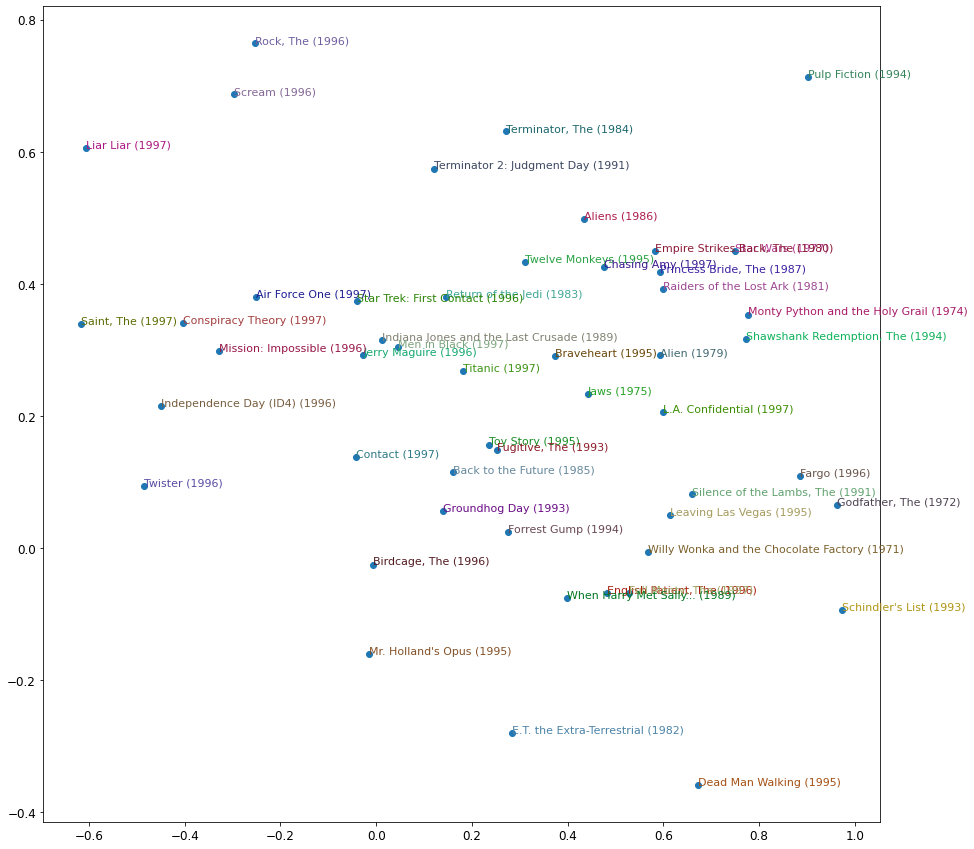

In [22]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()